In [ ]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

We're going to look at recipes. Specifically we'll use the epicurious dataset, which has a collection of recipes, key terms and ingredients, and their ratings.

We want to see is if we can use the ingredient and keyword list to predict the rating. For someone writing a cookbook this could be really useful information that could help them choose which recipes to include because they're more likely to be enjoyed and therefore make the book more likely to be successful.

First let's load the dataset. It's [available on Kaggle](https://www.kaggle.com/hugodarwood/epirecipes). We'll use the csv file here and as pull out column names and some summary statistics for ratings.

In [ ]:
raw_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv')

In [ ]:
# list(ratings_df.columns)
raw_data.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,advance prep required,alabama,alaska,alcoholic,almond,amaretto,anchovy,anise,anniversary,anthony bourdain,aperitif,appetizer,apple,apple juice,apricot,arizona,artichoke,arugula,asian pear,asparagus,aspen,atlanta,australia,avocado,back to school,backyard bbq,bacon,bake,banana,...,vegan,vegetable,vegetarian,venison,vermont,vermouth,vinegar,virginia,vodka,waffle,walnut,wasabi,washington,"washington, d.c.",watercress,watermelon,wedding,weelicious,west virginia,westwood,wheat/gluten-free,whiskey,white wine,whole wheat,wild rice,windsor,wine,winter,wisconsin,wok,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

We learn a few things from this analysis. From a ratings perspective, there are just over 20,000 recipes with an average rating of 3.71. What is interesting is that the 25th percentile is actually above the mean. This means there is likely some kind of outlier population. This makes sense when we think about reviews: some bad recipes may have very few very low reviews.

Let's validate the idea a bit further with a histogram.

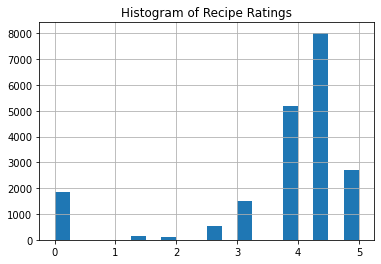

In [ ]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

There are sharp discontinutities. We don't have continuous data. No recipe has a 3.5 rating, for example. Also we see the anticipated increase at 0.

Let's try a naive approach again, this time using SVM Regressor. But first, we'll have to do a bit of data cleaning.

In [ ]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

Wwe can see that nutrition information is not available for all goods. Now this would be an interesting data point, but let's focus on ingredients and keywords right now. So we'll actually drop the whole columns for calories, protein, fat, and sodium. 

We'll come back to nutrition information later.

In [ ]:
from sklearn.svm import SVR
svr = SVR()
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1).sample(frac=0.3, replace=True, random_state=1)
# X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
Y = raw_data.rating.sample(frac=0.3, replace=True, random_state=1)
svr.fit(X,Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

We'll move on to the scores of both our full fit model and with cross validation. Again if you choose to run it again it will take some time, so you probably shouldn't.

In [ ]:
svr.score(X, Y)

0.4099845913800794

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(svr, X, Y, cv=5)

array([0.19563385, 0.14683481, 0.15013401, 0.13597791, 0.16082192])

__Regression results:__

This did seem not to work very well as a regression problem. It scored remarkably poor. 

__We could take our regression problem and turn it into a classifier. With this number of features and a discontinuous outcome, we might have better luck thinking of this as a classification problem. We could make it simpler still by instead of classifying on each possible value, group reviews to some decided high and low values.__

Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features. 

In [ ]:
# Turn target variable into classification.  Set ratings of 3.5+ as 'good'.
raw_data['rating_new'] = raw_data['rating'] >= 3.5

In [ ]:
#----Classification model using PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = raw_data.drop(['rating', 'rating_new', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
Y = raw_data['rating_new']

pca = PCA(n_components=30)
X_new = pca.fit_transform(X)

svc = SVC()
svc.fit(X_new, Y)
print(svc.score(X_new, Y))
print(cross_val_score(svc, X_new, Y, cv=5))

0.8030121683622581
[0.80079781 0.80204438 0.80349127 0.80124688 0.80149626]


Model accuracy improved tremendously using SVC and PCA.